## Set up your environment
To create the correct environment for geoprocessing, you will first need to import some additional modules in the code cell below.  The ArcPy package contains all the geoprocessing functions within ArcGIS Pro.  The arcgis.gis module contains classes and methods for accessing items stored on ArcGIS Online.  The pandas library contains classes and methods for working with tabular data.

Run the code cell below by selecting it and pressing Shift+Enter. 

In [1]:
import arcpy
from arcgis.gis import GIS
import pandas as pd

By default, the output of any geoprocessing tool you run will be saved to the project geodatabase, but it is a good idea to set the current workspace explicitly anyway.  Define that workspace in the second cell of your notebook.  The file path below is just an example - you should use the actual file path of the location where you want your output to be stored.  For this tutorial, the workspace variable is the only code you will need to alter, until you get to the practice exercises and assessment at the end. 

In [2]:
workspace = r'C:\file\path\to\project.gdb'
arcpy.env.workspace = workspace

## Access data
For this tutorial, the data are stored as a feature layer collection on ArcGIS Online.  In the next cell, you will need to create a GIS object so that you can connect to ArcGIS Online:


In [3]:
gis = GIS('Pro')

Now that you can connect to the service, in the next cell, access the feature layer collection for this tutorial by using its content ID number.

In [4]:
data = gis.content.get('0b028b120b0e41ba833ce47312222c49')

Feature layer collections and the layers inside them are not valid inputs for ArcPy’s geoprocessing functions.  In the next cell, you will need to save these data locally as feature classes in your workspace.  To do that, iterate through all the feature layers in the feature layer collection, converting each one to a spatial data frame using pandas, and then exporting it to a feature class.  Since you already defined the workspace, you only need to specify the name of the feature class in the location parameter, and it will automatically save to your workspace.

In [5]:
for feature_layer in data.layers:
    sdf = pd.DataFrame.spatial.from_layer(feature_layer)
    sdf.spatial.to_featureclass(location=feature_layer.properties.name)

## ArcPy spatial join tool
The assessment in the first tutorial required you to join building attribute data to its associated address point.  Since not all the address points were located inside their building, one way to solve the problem was to use the “Closest” match option with a search radius of 30 meters.  Using the Geoprocessing pane in ArcGIS Pro, the tool parameters for that join would look like this: 
<br>


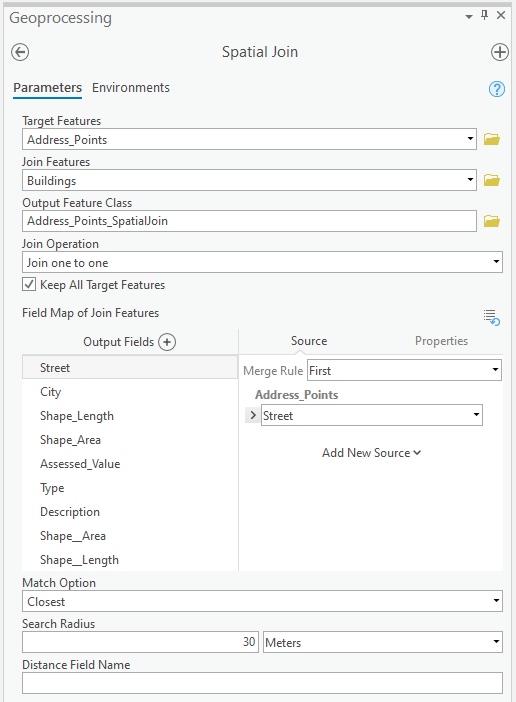

<br>

Anything you can do in the geoprocessing pane, you can also do with ArcPy.  The most pythonic way to script the necessary spatial join is to assign each of the parameter values to a variable, and then pass the variable as a parameter to the spatial join function:

In [6]:
#define parameters
target_features=os.path.join(workspace, 'Address_Points')
join_features=os.path.join(workspace, 'Buildings')
out_feature_class='Address_with_building'
join_operation='JOIN_ONE_TO_ONE'
join_type = 'KEEP_ALL'
match_option='CLOSEST'
search_radius='30 Meters'


#run the tool w/ defined parameters
arcpy.analysis.SpatialJoin(target_features=target_features, 
                           join_features=join_features, 
                           out_feature_class=out_feature_class, 
                           join_operation=join_operation, 
                           join_type=join_type,  
                           match_option=match_option, 
                           search_radius=search_radius)

<Result 'C:\\Users\\orms0027\\Documents\\ArcGIS\\Projects\\EX07\\EX07.gdb\\Address_with_building'>

You can find the full documentation for the spatial tool [here](https://pro.arcgis.com/en/pro-app/tool-reference/analysis/spatial-join.htm).  The documentation defines all the parameters (only some of which are used in the example above) and provides some additional examples of how to use the tool.

## The “Copy Python command” shortcut
If you have previously run a geoprocessing tool and you want to re-run the tool again in a script, there is an easy way to generate Python code to duplicate that tool run.  In the Analysis ribbon in ArcGIS Pro, locate the Geoprocessing group and select History:

<br>

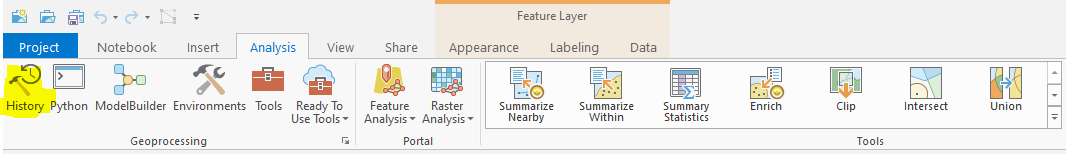

<br>


This will bring up the history pane, which will show you all of the geoprocessing tools you have ever run in your project.  You can right click on one of these operations and select “Copy Python command”.  The command to replicate the operation you just ran will look something like this:

```
arcpy.analysis.SpatialJoin("Address_Points", "Buildings", r"file\path\to\database.gdb\Address_with_building", "JOIN_ONE_TO_ONE", "KEEP_ALL", 'Street "Street" true true false 36 Text 0 0,First,#,Address_Points,Street,0,36;City "City" true true false 24 Text 0 0,First,#,Address_Points,City,0,24;Shape_Length "Shape_Length" false true true 8 Double 0 0, First, #, Buildings, Shape_Length, -1, -1; Shape_Area "Shape_Area" false true true 8 Double 0 0, First, #, Buildings, Shape_Area, -1, -1; Assessed_Value "Assessed_Value" true true false 508 Text 0 0, First, #, Buildings, Assessed_Value, 0, 508; Type "Type" true true false 4 Long 0 0, First, #, Buildings, Type, -1, -1; Description "Description" true true false 58 Text 0 0, First, #, Buildings, Description, 0, 58; Shape__Area "Shape__Area" true true false 8 Double 0 0, First, #, Buildings, Shape__Area, -1, -1; Shape__Length "Shape__Length" true true false 8 Double 0 0, First, #, Buildings, Shape__Length, -1, -1', "CLOSEST", "10 Meters", '')
```

This code is horribly unreadable, but it does work.  If you look hard enough, you can match up each of the parameters to those described in the documentation.

So if this code is so ugly, why bother?  If you have a tricky spatial join that you need to make sure works correctly before you incorporate it into a larger script, it can be easier to prototype the join using the geoprocessing pane.  After you know you have the correct parameters, you can copy the Python command and paste it into your script.


## Field mapping objects
In the assessment for the second tutorial, you calculated the total value of assessed property in each city.  Because each city had multiple property parcels, in the field map  you needed to use a merge rule of “Sum” for the Assessed_Value output field:

<br>

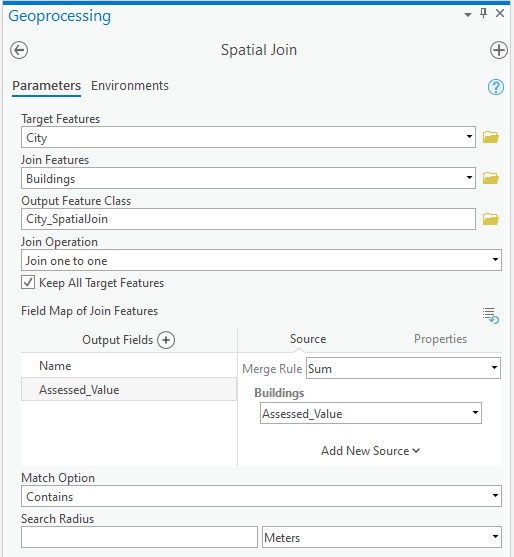

<br>



When you are scripting your spatial join, the field_mappings parameter is optional.  If you don’t set it, it will default to include every field in both feature classes, with a merge rule of “First”.  You can set the field map parameter with a string, just like all the other parameters.  Unfortunately, even for the relatively simple field map above, that string is complex and unreadable:

```
Name "Name" true true false 12 Text 0 0, First, #, County, Name, 0, 12; Assessed_Value "Assessed_Value" true true false 4 Long 0 0, Sum, #, Buildings, Assessed_Value, -1, -1
```

You could study how these strings are formatted and use Python to directly generate your own field map strings, but ArcPy has built in methods to make it easier.  

First, create an empty FieldMappings object.  The FieldMappings is the collection of all the different output field maps.  


In [13]:
field_mapping = arcpy.FieldMappings()

Now you need to create two different FieldMap objects, one for each of the two fields in our output feature class. 

In [14]:
name = arcpy.FieldMap()
total_val = arcpy.FieldMap()

These two FieldMap objects are empty when you first create them.  You need to define which fields go into the map and how those fields should be combined.  The “name” FieldMap uses the “Name” field from the County feature class and doesn't need a merge rule because we're not combining counties together.  The “total_val” FieldMap uses the “Assessed_Value” field from the Buildings feature class, and needs a merge rule of “Sum”.

In [15]:
name.addInputField('City', 'Name')

total_val.addInputField('Buildings', 'Assessed_Value')
total_val.mergeRule = 'SUM'

You can also specify details of the output field, like its name and alias:

In [16]:
name_out = name.outputField
name_out.name = 'Name'
name_out.aliasName = 'Name'
name.outputField = name_out

total_val_out = total_val.outputField
total_val_out.name = 'Total_Prop_Val'
total_val_out.aliasName = 'Total Property Value'
total_val.outputField = total_val_out

To complete your FieldMappings object, you need to add your completed FieldMap objects to it (remember FieldMappings is just a container to hold your FieldMaps)

In [17]:
field_mapping.addFieldMap(name)
field_mapping.addFieldMap(total_val)

Now that your FieldMappings object is complete, define the rest of your spatial join parameters and pass them to the tool, just like you did before.  Notice how the code below passes the  field_mapping variable (which is a FieldMappings object) as a value for the tool’s field_mapping parameter: 

In [18]:
#define parameters
target_features=os.path.join(workspace, 'City')
join_features=os.path.join(workspace, 'Buildings')
out_feature_class='City_Prop_Val'
join_operation='JOIN_ONE_TO_ONE'
join_type = 'KEEP_ALL'
match_option='CONTAINS'

#run the tool w/ defined parameters
arcpy.analysis.SpatialJoin(target_features=target_features, 
                           join_features=join_features, 
                           out_feature_class=out_feature_class, 
                           join_operation=join_operation, 
                           join_type=join_type, 
                           field_mapping=field_mapping,
                           match_option=match_option)

<Result 'C:\\Users\\orms0027\\Documents\\ArcGIS\\Projects\\EX07\\EX07.gdb\\City_Prop_Val'>

For more information, check out the full documentation for the [FieldMappings](https://pro.arcgis.com/en/pro-app/arcpy/classes/fieldmappings.htm) and [FieldMap](https://pro.arcgis.com/en/pro-app/arcpy/classes/fieldmap.htm) objects.

## Running scripts from the command line
The Jupyter Notebooks built into ArcGIS Pro are great for prototyping.  But for running scripts in a production environment, you probably want to be able to execute them from the command line.

The easiest way to do this is to copy the code from your Jupyter Notebook into your favorite code editor and save it with a .py extension.  You can find an example script with all of the code in this tutorial in the directory you downloaded from GitHub.  If you run the example script, make sure you change the workspace variable so that your output is saved to the correct location.  

Open an application called “Python Command Prompt” that was installed alongside ArcGIS Pro.  Using this application will ensure that you are using the same Python environment that your Notebook was using.  That environment will be listed in parentheses before the command prompt.  Unless you have changed the default environment, it should say arcgispro-py3.

Navigate to the directory where your script is saved.  Type python your_script_name.py and hit enter to run your script.
<br>

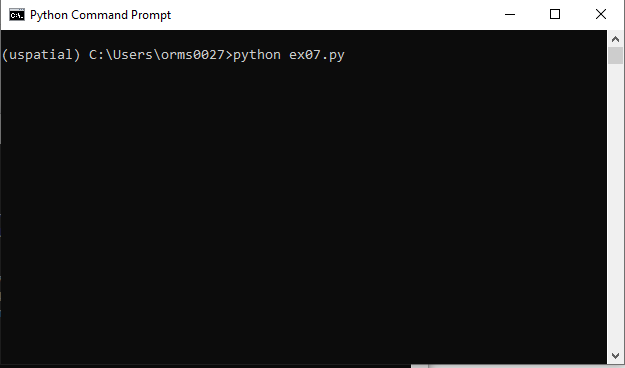


## Practice exercises

**1.** Without copying a Python command from the geoprocessing pane, recreate a spatial join you had previously run.  Compare the results to make sure they are identical.

   **Challenge:** Run your script from the command line

**2.** Copy the Python command for a spatial join you have previously completed.  Outside of ArcGIS Pro, from the command line, execute a script using the command you copied.

   **Challenge:** Clean up the code so it is readable before you run it.

**3.** Oak County has the highest mean building value at $1,164,711.  Can you write a Python script to prove it?

   **Challenge:** Output a single feature class that has each of the following fields for each county: number of buildings, mean building value, and median building value.  The attribute table should have these values:

<br>

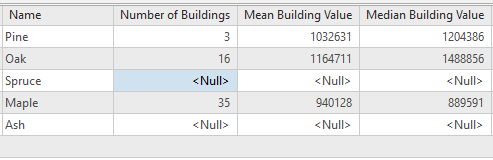

## Assessment
Use a loop to add the County name (but not any other county level data) to every feature in every point feature in class in this dataset.